<a href="https://colab.research.google.com/github/zhangxs131/Machine_learning_notebook/blob/main/svm_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM支持向量机分类

SVM就是先将低维数据通过适合核函数转为高维数据，然后找到一个分类超平面，将两类数据分隔到两侧，将问题转为求分类超平面方程问题，即带有约束条件的最优解问题，然后通过拉格朗日函数转为一个函数，进行求导，求解。

In [1]:
#下载一个test-data
!wget https://raw.githubusercontent.com/Jack-Cherish/Machine-Learning/master/SVM/testSet.txt

--2022-04-30 07:36:22--  https://raw.githubusercontent.com/Jack-Cherish/Machine-Learning/master/SVM/testSet.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2108 (2.1K) [text/plain]
Saving to: ‘testSet.txt’

testSet.txt         100%[===================>]   2.06K  --.-KB/s    in 0s      

2022-04-30 07:36:22 (31.0 MB/s) - ‘testSet.txt’ saved [2108/2108]



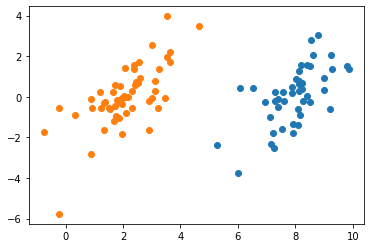

In [4]:
import numpy as np
import matplotlib.pyplot as plt

#数据可视化
def show_data(data,label):
  data_1=[]
  data_2=[]
  for i in range(len(label)):
    if label[i]>0:
      data_1.append(data[i])
    else:
      data_2.append(data[i])
  data_1=np.array(data_1)
  data_2=np.array(data_2)

  plt.figure()
  plt.scatter(np.transpose(data_1)[0],np.transpose(data_1)[1])
  plt.scatter(np.transpose(data_2)[0],np.transpose(data_2)[1])
  plt.show()

def load_data(file_name):
  with open(file_name,'r') as f:
    content=f.readlines()

  data=[]
  label=[ ]
  for i in content:
    t=i.strip().split('\t')
    data.append([float(j) for j in t[:-1]])
    label.append(float(t[-1]))
  return data,label

data,label=load_data('testSet.txt')
show_data(data,label)

##手写简化版SMO算法

即通过将一个大型优化问题，转换为多个小的优化问题来解决。

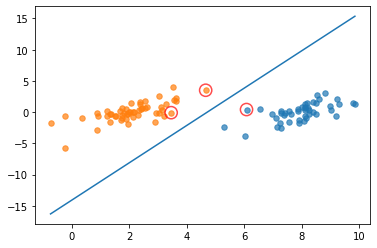

In [11]:
from time import sleep
import random
import types

#从0-m中选择一个不等于i的j值
def selectJrand(i,m):
  j=i
  while j==i:
    j=int(random.uniform(0,m))
  return j

#裁剪alpha,设置阈值
def clipAlpha(a,H,L):
  if a>H:
    return H
  elif L>a:
    return L
  else:
    return a

#简化版smo算法
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    #转换为numpy的mat存储
    dataMatrix = np.mat(dataMatIn); labelMat = np.mat(classLabels).transpose()
    #初始化b参数，统计dataMatrix的维度
    b = 0; m,n = np.shape(dataMatrix)
    #初始化alpha参数，设为0
    alphas = np.mat(np.zeros((m,1)))
    #初始化迭代次数
    iter_num = 0
    #最多迭代matIter次
    while (iter_num < maxIter):
        alphaPairsChanged = 0
        for i in range(m):
            #步骤1：计算误差Ei
            fXi = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b
            Ei = fXi - float(labelMat[i])
            #优化alpha，更设定一定的容错率。
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                #随机选择另一个与alpha_i成对优化的alpha_j
                j = selectJrand(i,m)
                #步骤1：计算误差Ej
                fXj = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b
                Ej = fXj - float(labelMat[j])
                #保存更新前的aplpha值，使用深拷贝
                alphaIold = alphas[i].copy(); alphaJold = alphas[j].copy();
                #步骤2：计算上下界L和H
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                #if L==H: print("L==H"); continue
                #步骤3：计算eta
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
                #if eta >= 0: print("eta>=0"); continue
                #步骤4：更新alpha_j
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                #步骤5：修剪alpha_j
                alphas[j] = clipAlpha(alphas[j],H,L)
                # if (abs(alphas[j] - alphaJold) < 0.00001): print("alpha_j变化太小"); continue
                #步骤6：更新alpha_i
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])
                #步骤7：更新b_1和b_2
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T
                #步骤8：根据b_1和b_2更新b
                if (0 < alphas[i]) and (C > alphas[i]): b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): b = b2
                else: b = (b1 + b2)/2.0
                #统计优化次数
                alphaPairsChanged += 1
                #打印统计信息
                #print("第%d次迭代 样本:%d, alpha优化次数:%d" % (iter_num,i,alphaPairsChanged))
        #更新迭代次数
        if (alphaPairsChanged == 0): iter_num += 1
        else: iter_num = 0
        #print("迭代次数: %d" % iter_num)
    return b,alphas


def showClassifer(dataMat,labelMat, w, b):
    #绘制样本点
    data_plus = []                                  #正样本
    data_minus = []                                 #负样本
    for i in range(len(dataMat)):
        if labelMat[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)              #转换为numpy矩阵
    data_minus_np = np.array(data_minus)            #转换为numpy矩阵
    plt.scatter(np.transpose(data_plus_np)[0], np.transpose(data_plus_np)[1], s=30, alpha=0.7)   #正样本散点图
    plt.scatter(np.transpose(data_minus_np)[0], np.transpose(data_minus_np)[1], s=30, alpha=0.7) #负样本散点图
    #绘制直线
    x1 = max(dataMat)[0]
    x2 = min(dataMat)[0]
    a1, a2 = w
    b = float(b)
    a1 = float(a1[0])
    a2 = float(a2[0])
    y1, y2 = (-b- a1*x1)/a2, (-b - a1*x2)/a2
    plt.plot([x1, x2], [y1, y2])
    #找出支持向量点
    for i, alpha in enumerate(alphas):
        if alpha > 0:
            x, y = dataMat[i]
            plt.scatter([x], [y], s=150, c='none', alpha=0.7, linewidth=1.5, edgecolor='red')
    plt.show()

def get_w(dataMat, labelMat, alphas):
    alphas, dataMat, labelMat = np.array(alphas), np.array(dataMat), np.array(labelMat)
    w = np.dot((np.tile(labelMat.reshape(1, -1).T, (1, 2)) * dataMat).T, alphas)
    return w.tolist()

b,alphas = smoSimple(data,label, 0.6, 0.001, 40)
w = get_w(data, label, alphas)
showClassifer(data,label, w, b)